
# EEG Data Analysis using Recurrent Neural Networks

This notebook demonstrates the analysis of EEG (Electroencephalogram) data using recurrent neural networks (RNNs). We will use a real EEG dataset from the UCI Machine Learning Repository, preprocess it, extract features, train an LSTM model, and evaluate its performance.


In [ ]:
!pip install ucimlrepo


## Data Loading

We will load the EEG Eye State dataset from the UCI Machine Learning Repository using the `ucimlrepo` package.


In [ ]:

from ucimlrepo import fetch_ucirepo

# fetch dataset
eeg_eye_state = fetch_ucirepo(id=264)

# data (as pandas dataframes)
X = eeg_eye_state.data.features
y = eeg_eye_state.data.targets

# metadata
print(eeg_eye_state.metadata)

# variable information
print(eeg_eye_state.variables)


{'uci_id': 264, 'name': 'EEG Eye State', 'repository_url': 'https://archive.ics.uci.edu/dataset/264/eeg+eye+state', 'data_url': 'https://archive.ics.uci.edu/static/public/264/data.csv', 'abstract': 'The data set consists of 14 EEG values and a value indicating the eye state.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 14980, 'num_features': 14, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['eyeDetection'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Thu Mar 21 2024', 'dataset_doi': '10.24432/C57G7J', 'creators': ['Oliver Roesler'], 'intro_paper': None, 'additional_info': {'summary': "All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measuremen


## Variable Explanations

The dataset consists of EEG measurements with the following variables:

- **1-14**: These are the electrode positions according to the 10-20 system of electrode placement. Each column represents the voltage measured at a specific electrode.
- **Eye State**: The class label indicating whether the eye is open or closed.

Each row represents a single EEG recording with measurements from multiple electrodes.



## Data Preprocessing

We will preprocess the data by handling missing values and normalizing it.


In [ ]:
import pandas as pd

# Check for missing values
print("Missing values per column:\n", X.isnull().sum())

# Fill missing values with column mean
X = X.fillna(X.mean())

# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for consistency
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


Missing values per column:
 AF3    0
F7     0
F3     0
FC5    0
T7     0
P7     0
O1     0
O2     0
P8     0
T8     0
FC6    0
F4     0
F8     0
AF4    0
dtype: int64



## Exploratory Data Analysis

We will visualize the EEG signals to understand the data better and perform some basic statistical analysis.


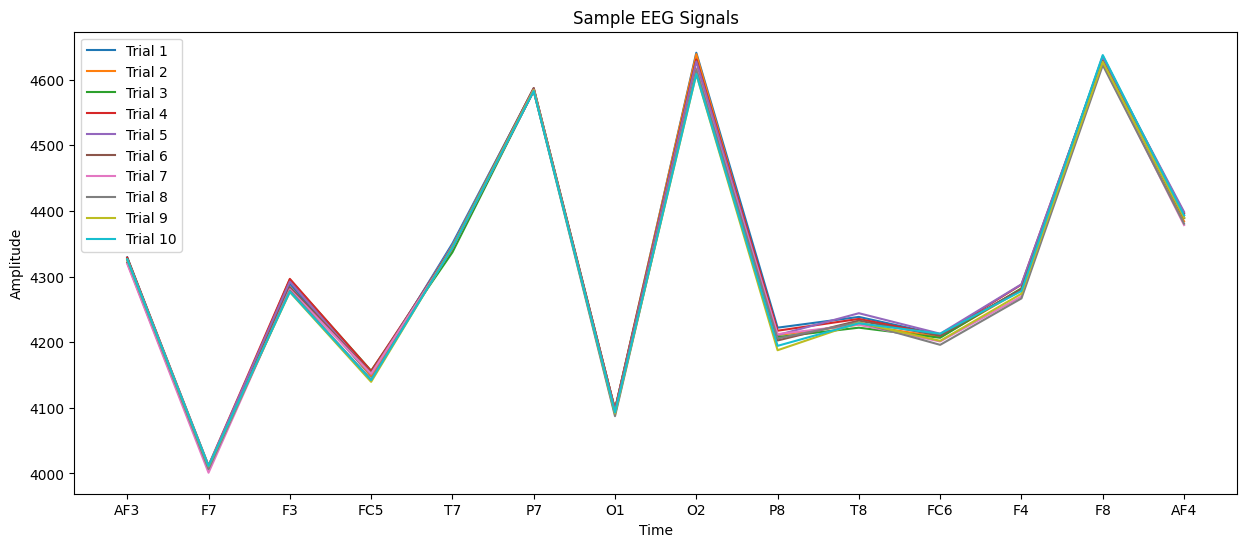

                 AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.620000   6880.510000  642564.000000   6474.360000   

                  P7             O1            O2             P8  \
count   14980.000000   14980.000000  14980.000000   14980.000000   
mean     4644.022379    4110.400160   4616.056904    4218.826610   
std      2924.789537    4600.926543     29.292603    2136.408523  

In [ ]:
import matplotlib.pyplot as plt

# Plot sample EEG signals
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.plot(X.iloc[i], label=f'Trial {i+1}')
plt.title('Sample EEG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Statistical analysis
summary_stats = X.describe()
print(summary_stats)



## Recurrent Neural Network Model Training

We will train an LSTM network for EEG signal classification. LSTM is a type of RNN that is well-suited for sequential data.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data for LSTM [samples, time steps, features]
X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
150/150 [==============================] - 38s 229ms/step - loss: 0.6764 - accuracy: 0.5657 - val_loss: 0.6541 - val_accuracy: 0.5870
Epoch 2/100
150/150 [==============================] - 1s 10ms/step - loss: 0.6612 - accuracy: 0.5978 - val_loss: 0.6365 - val_accuracy: 0.6245
Epoch 3/100
150/150 [==============================] - 1s 9ms/step - loss: 0.6470 - accuracy: 0.6180 - val_loss: 0.6242 - val_accuracy: 0.6283
Epoch 4/100
150/150 [==============================] - 2s 15ms/step - loss: 0.6219 - accuracy: 0.6350 - val_loss: 0.6031 - val_accuracy: 0.6525
Epoch 5/100
150/150 [==============================] - 4s 26ms/step - loss: 0.6027 - accuracy: 0.6558 - val_loss: 0.5816 - val_accuracy: 0.6713
Epoch 6/100
150/150 [==============================] - 1s 10ms/step - loss: 0.6320 - accuracy: 0.6654 - val_loss: 0.5761 - val_accuracy: 0.6809
Epoch 7/100
150/150 [==============================] - 1s 9ms/step - loss: 0.5786 - accuracy: 0.6749 - val_loss: 0.5648 - val_accuracy:


## Model Evaluation

We will evaluate the LSTM model's performance using various metrics.


In [21]:
from sklearn.metrics import classification_report

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))


94/94 [==============================] - 0s 3ms/step - loss: 0.2876 - accuracy: 0.8738
Test Accuracy: 0.8738317489624023
94/94 [==============================] - 1s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      1586
           1       0.88      0.85      0.86      1410

    accuracy                           0.87      2996
   macro avg       0.87      0.87      0.87      2996
weighted avg       0.87      0.87      0.87      2996




## Conclusion

We analyzed EEG data, extracted features, trained an LSTM network, and evaluated its performance. This demonstrates the process of using deep learning, specifically RNNs, for EEG signal analysis.
